# Regularized Linear Regression and Bias v.s.Variance 

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as scio
import scipy.optimize as opt
import seaborn as sns

In [36]:
data = scio.loadmat('ex5data1.mat')
X, y = data['X'].ravel(), data['y'].ravel()
X_val, y_val = data['Xval'].ravel(), data['yval'].ravel()
X_test,y_test = data['Xtest'].ravel(), data['ytest'].ravel()

## Visualizing the dataset

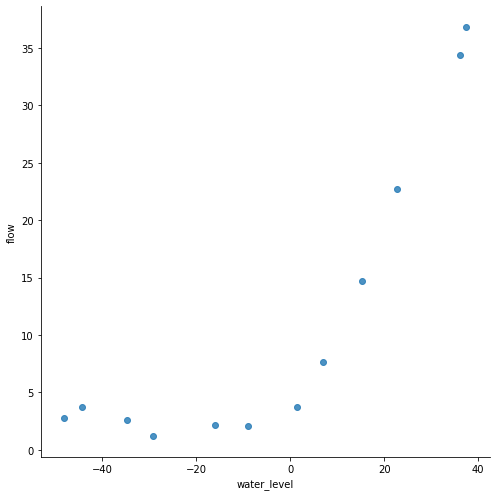

In [15]:
df = pd.DataFrame({'water_level':X, 'flow':y})
sns.lmplot('water_level', 'flow', data=df, fit_reg=False, size=7)
plt.show()

In [17]:
X, X_val, X_test = [np.insert(x.reshape(x.shape[0], 1), 0, np.ones(x.shape[0]), axis=1) for x in (X, X_val, X_test)]

## Regularized linear regression cost function

In [18]:
def cost(theta, X, y):
    m = X.shape[0]
    error = X @ theta - y  # R(m*1)
    cost = error.T @ error / (2 * m)

    return cost

In [19]:
theta = np.ones(X.shape[1])
cost(theta, X, y)

303.9515255535976

## Regularized linear regression gradient

In [23]:
def gradient(theta, X, y):
    m = X.shape[0]
    inner = X.T @ (X @ theta - y)  # (m,n).T @ (m, 1) -> (n, 1)
    return inner / m

In [24]:
def regularized_gradient(theta, X, y, l=1):
    m = X.shape[0]

    regularized_term = theta.copy()  # same shape as theta
    regularized_term[0] = 0  # don't regularize intercept theta

    regularized_term = (l / m) * regularized_term

    return gradient(theta, X, y) + regularized_term

In [25]:
regularized_gradient(theta, X, y)

array([-15.30301567, 598.25074417])

## Fitting linear regression

In [26]:
def linear_regression_np(X, y, l=1):
    # init theta
    theta = np.ones(X.shape[1])
    # train it
    res = opt.minimize(fun=regularized_cost,x0=theta,args=(X, y, l),method='TNC',jac=regularized_gradient,options={'disp': True})
    return res

In [27]:
def regularized_cost(theta, X, y, l=1):
    m = X.shape[0]

    regularized_term = (l / (2 * m)) * np.power(theta[1:], 2).sum()

    return cost(theta, X, y) + regularized_term

In [28]:
theta = np.ones(X.shape[0])

final_theta = linear_regression_np(X, y, l=0).get('x')

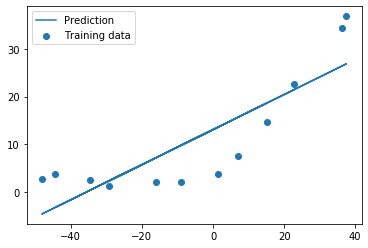

In [30]:
b = final_theta[0] # intercept
m = final_theta[1] # slope

plt.scatter(X[:,1], y, label="Training data")
plt.plot(X[:, 1], X[:, 1]*m + b, label="Prediction")
plt.legend(loc=2)
plt.show()

In [31]:
training_cost, cv_cost = [], []

In [32]:
m = X.shape[0]
for i in range(1, m+1):
    res = linear_regression_np(X[:i, :], y[:i], l=0)
    
    tc = regularized_cost(res.x, X[:i, :], y[:i], l=0)
    cv = regularized_cost(res.x, X_val, y_val, l=0)
    
    training_cost.append(tc)
    cv_cost.append(cv)

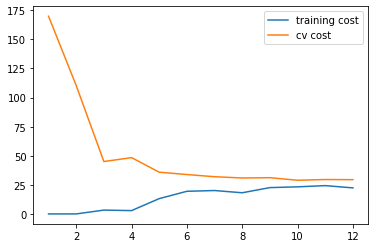

In [33]:
plt.plot(np.arange(1, m+1), training_cost, label='training cost')
plt.plot(np.arange(1, m+1), cv_cost, label='cv cost')
plt.legend(loc=1)
plt.show()

## Polynomial regression

In [34]:
def prepare_poly_data(*args, power):
    def prepare(x):
        df = poly_features(x, power=power)
        ndarr = normalize_feature(df).as_matrix()

        return np.insert(ndarr, 0, np.ones(ndarr.shape[0]), axis=1)

    return [prepare(x) for x in args]

In [35]:
def poly_features(x, power, as_ndarray=False):
    data = {'f{}'.format(i): np.power(x, i) for i in range(1, power + 1)}
    df = pd.DataFrame(data)

    return df.as_matrix() if as_ndarray else df

In [37]:
poly_features(X, power=3)

,f1,f2,f3
0,-15.936758,253.980260,-4047.621971
1,-29.152979,849.896197,-24777.006175
2,36.189549,1309.683430,47396.852168
3,37.492187,1405.664111,52701.422173
4,-48.058829,2309.651088,-110999.127750
5,-8.941458,79.949670,-714.866612
6,15.307793,234.328523,3587.052500
7,-34.706266,1204.524887,-41804.560890
8,1.389154,1.929750,2.680720
9,-44.383760,1969.918139,-87432.373590


In [38]:
def normalize_feature(df):
    """Applies function along input axis(default 0) of DataFrame."""
    return df.apply(lambda column: (column - column.mean()) / column.std())

In [39]:
X_poly, Xval_poly, Xtest_poly= prepare_poly_data(X, X_val, X_test, power=8)
X_poly[:3, :]

array([[ 1.00000000e+00, -3.62140776e-01, -7.55086688e-01,
         1.82225876e-01, -7.06189908e-01,  3.06617917e-01,
        -5.90877673e-01,  3.44515797e-01, -5.08481165e-01],
       [ 1.00000000e+00, -8.03204845e-01,  1.25825266e-03,
        -2.47936991e-01, -3.27023420e-01,  9.33963187e-02,
        -4.35817606e-01,  2.55416116e-01, -4.48912493e-01],
       [ 1.00000000e+00,  1.37746700e+00,  5.84826715e-01,
         1.24976856e+00,  2.45311974e-01,  9.78359696e-01,
        -1.21556976e-02,  7.56568484e-01, -1.70352114e-01]])

## lambda = 0

In [43]:
def plot_learning_curve(X, y, X_val, y_val, l=0):
    training_cost, cv_cost = [], []
    m = X.shape[0]

    for i in range(1, m + 1):
        res = linear_regression_np(X[:i, :], y[:i], l=l)
        tc = cost(res.x, X[:i, :], y[:i])
        cv = cost(res.x, X_val, y_val)

        training_cost.append(tc)
        cv_cost.append(cv)

    plt.plot(np.arange(1, m + 1), training_cost, label='training cost')
    plt.plot(np.arange(1, m + 1), cv_cost, label='cv cost')
    plt.legend(loc=1)

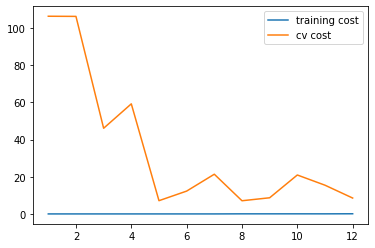

In [44]:
plot_learning_curve(X_poly, y, Xval_poly, y_val, l=0)
plt.show()

**训练cost太低、验证集cost较高，此时过拟合**

## lambda = 1

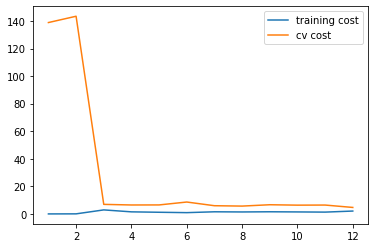

In [45]:
plot_learning_curve(X_poly, y, Xval_poly, y_val, l=1)
plt.show()

**此时仍为过拟合，但训练集cost增加，为减轻过拟合**

## lambda = 100

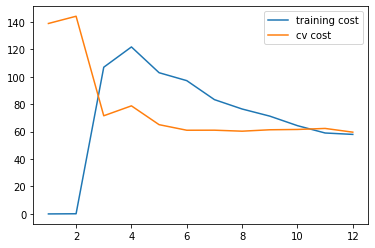

In [47]:
plot_learning_curve(X_poly, y, Xval_poly, y_val, l=100)
plt.show()

**此时为欠拟合，训练集cost、验证集cost都还较高**

## Choice lambda

In [48]:
l_candidate = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
training_cost, cv_cost = [], []

In [50]:
for l in l_candidate:
    res = linear_regression_np(X_poly, y, l)
    
    tc = cost(res.x, X_poly, y)
    cv = cost(res.x, Xval_poly, y_val)
    
    training_cost.append(tc)
    cv_cost.append(cv)

In [53]:
l_candidate[np.argmin(cv_cost)]
for l in l_candidate:
    theta = linear_regression_np(X_poly, y, l).x
    print('test cost(l={}) = {}'.format(l, cost(theta, Xtest_poly, y_test)))

test cost(l=0) = 10.804375286491785
test cost(l=0.001) = 10.911365745177878
test cost(l=0.003) = 11.265060784108712
test cost(l=0.01) = 10.879143763702967
test cost(l=0.03) = 10.022378551698187
test cost(l=0.1) = 8.631776100446476
test cost(l=0.3) = 7.3365081011786275
test cost(l=1) = 7.466282452677015
test cost(l=3) = 11.643940740451052
test cost(l=10) = 27.715080273166386


$\lambda = 0.3$ 是最优选择